# **Liveness Detection**


## Import Library

In [ ]:
import tensorflow as tf
import os
print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.15.0
Mounted at /content/drive


#### Unzip Dataset

In [ ]:
import zipfile, os

local_zip = '/content/drive/MyDrive/data_compound.zip'
#local_zip = '/content/drive/MyDrive/dataset_edited.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Dataset')
zip_ref.close()

#### Check Source Path

In [ ]:
source_dir = '/content/Dataset'
print("folders:", os.listdir(source_dir))
#########
real_samples_dir = os.path.join(source_dir, 'real')
spoof_samples_dir = os.path.join(source_dir, 'spoof')

real_samples_count = len(os.listdir(real_samples_dir))
spoof_samples_count = len(os.listdir(spoof_samples_dir))

print('Number of Real Images : {}'.format(real_samples_count))
print('Number of Spoof Images : {}'.format(spoof_samples_count))
print('Total Images : {}'.format(real_samples_count + spoof_samples_count))


folders: ['spoof', 'real']
Number of Real Images : 5217
Number of Spoof Images : 5148
Total Images : 10365


#Dataset Preprcoess

#### Helper Functions

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

def make_square(image):
    img = img_to_array(image)
    h, w = img.shape[:2]
    size = max(h, w)

    # Create a new image with a white background
    new_img = np.ones((size, size, 3), dtype=np.uint8) * 255

    # Place the original image in the center
    if h > w:
        new_img[:, (size-w)//2:(size-w)//2 + w, :] = img
    else:
        new_img[(size-h)//2:(size-h)//2 + h, :, :] = img

    return array_to_img(new_img)

# Create a custom ImageDataGenerator
class CustomImageDataGenerator(ImageDataGenerator):
    def flow(self, x, y=None, batch_size=32, shuffle=True, **kwargs):
        self.samples = x.shape[0]
        self.batch_size = batch_size
        return super().flow(x, y, batch_size=batch_size, shuffle=shuffle, **kwargs)



#### Resize Images / and Assign Labels to them

In [ ]:
from imutils import paths
import random
import cv2
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Initialize the data and labels
data = []
labels = []

img_height, img_width = 128, 128

# Grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(source_dir)))
random.seed(42)
random.shuffle(imagePaths)

# Loop over the input images
for imagePath in imagePaths:
    # Load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (img_height, img_width))
    image = img_to_array(image)
    data.append(image)

    # Extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    label = 1 if label == "spoof" else 0
    labels.append(label)

# Scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

print(f"Total Count of Samples and Labels: {len(data)}")



Total Count of Samples and Labels: 10365


## Split Data Into Training and Testing

In [ ]:
# Partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
channels = trainX.shape[3]

# Convert the labels from integers to vectors
num_classes = 2  # Assuming binary classification (fake or real)
trainY = to_categorical(trainY, num_classes)
testY = to_categorical(testY, num_classes)

Batch_Size=64

# Construct the image generator for data augmentation
train_datagen = CustomImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

validation_datagen = CustomImageDataGenerator()

# Creating data generators
train_generator = train_datagen.flow(
    trainX,
    trainY,
    batch_size=Batch_Size
)

validation_generator = validation_datagen.flow(
    testX,
    testY,
    batch_size=Batch_Size
)

# Analysis the Train/Val samples

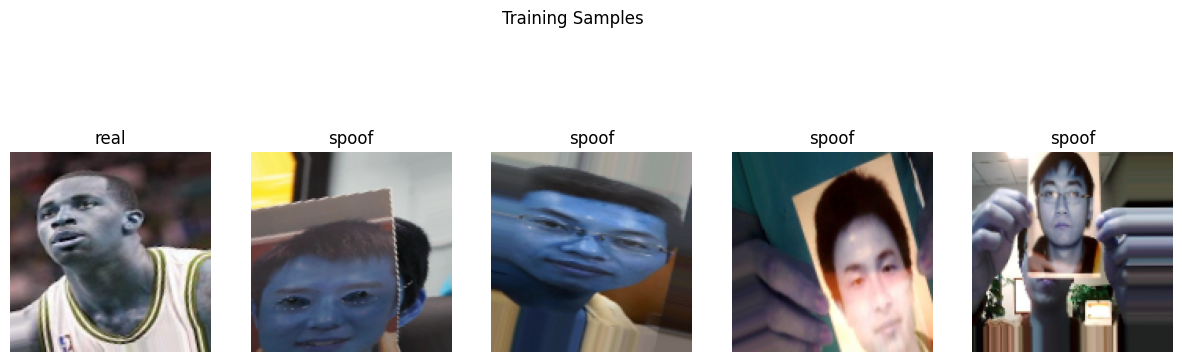

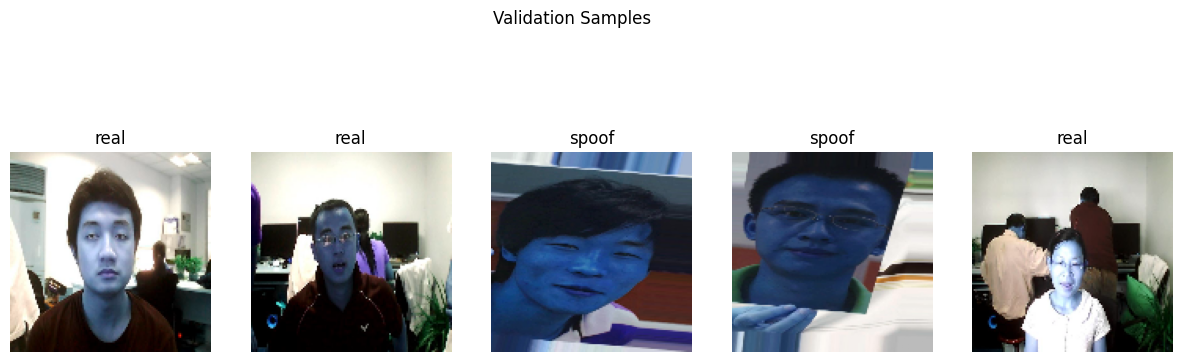

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Plotting samples from train and validation generators
def plot_samples(generator, class_names, title, num_samples=5):
    x_batch, y_batch = next(generator)  # Get a batch of images and labels
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(x_batch[i])
        label = class_names[int(np.argmax(y_batch[i]))]
        plt.title(label)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


# Class names
class_names = ['real', 'spoof']

# Plot samples from training generator
plot_samples(train_generator, class_names, "Training Samples")

# Plot samples from validation generator
plot_samples(validation_generator, class_names, "Validation Samples")

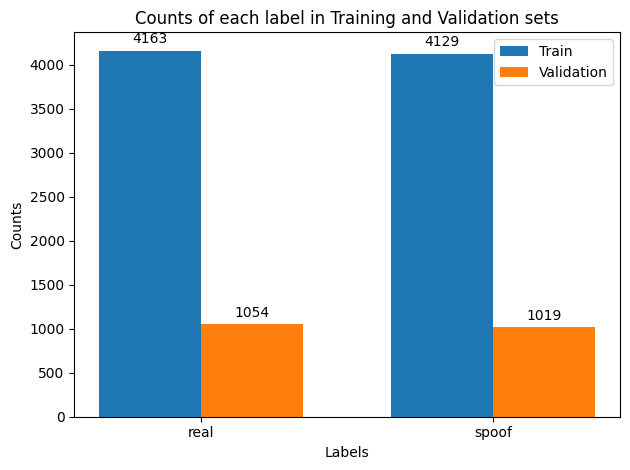

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_label_counts(train_counts, val_counts, class_names):
    labels = list(class_names)
    train_values = [train_counts.get(i, 0) for i in range(len(class_names))]
    val_values = [val_counts.get(i, 0) for i in range(len(class_names))]

    x = np.arange(len(labels))  # label locations
    width = 0.35  # bar width

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, train_values, width, label='Train')
    rects2 = ax.bar(x + width/2, val_values, width, label='Validation')

    # Add text for labels, title, and custom x-axis tick labels
    ax.set_xlabel('Labels')
    ax.set_ylabel('Counts')
    ax.set_title('Counts of each label in Training and Validation sets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add counts on top of the bars
    def add_counts(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_counts(rects1)
    add_counts(rects2)

    fig.tight_layout()
    plt.show()

# Reset the generators to count all the labels from the beginning
train_generator.reset()
validation_generator.reset()

# Initialize dictionaries to store label counts
train_labels_count = {}
val_labels_count = {}

# Iterate through the training set
for _ in range(len(train_generator)):
    batch_x, batch_y = train_generator.next()
    for label in batch_y.argmax(axis=1):
        train_labels_count[label] = train_labels_count.get(label, 0) + 1

# Iterate through the validation set
for _ in range(len(validation_generator)):
    batch_x, batch_y = validation_generator.next()
    for label in batch_y.argmax(axis=1):
        val_labels_count[label] = val_labels_count.get(label, 0) + 1

# Plot the label counts
plot_label_counts(train_labels_count, val_labels_count, class_names)


In [ ]:
advkjds5*d=''

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (<ipython-input-13-5b4056e70dcc>, line 1)

#Construct Model Using CNN and train them

### Model 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from keras.optimizers import Adam

def MiniVGG(width, height, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    chan_dim = -1

    if K.image_data_format() == "channels_first":
        input_shape = (depth, height, width)
        chan_dim = 1

    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chan_dim))

    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chan_dim))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chan_dim))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

img_height=128 # height of the training image
img_width=128 #width of the training image
EPOCHS = 20 #number of epochs to be trained for
num_classes=2 #number of labels
LR=1e-3
BS = 8 # Bach size to feed

# Define the model checkpoint callback
checkpoint_path = "/content/drive/MyDrive/spoof_checkpoint/model_decay.hdf5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

# initialize the model
print("Compiling model...")
model_1 = MiniVGG(width=img_width, height=img_height, depth=channels, classes=num_classes)
opt = Adam(learning_rate=lr_schedule) #Optimise using Adam with learning rate schedule
model_1.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

print(model_1.summary())


Compiling model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 activation_20 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_16 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 activation_21 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_17 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                 

In [ ]:
# Train the model using generators
history = model_1.fit(
    train_generator,
    steps_per_epoch=len(trainX) // Batch_Size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(testX) // Batch_Size,
    callbacks=[checkpoint_callback],
    verbose=1
)


Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.7899
Epoch 1: val_loss improved from inf to 9.86671, saving model to /content/drive/MyDrive/spoof_checkpoint/model_decay.hdf5
129/129 [==============================] - 48s 342ms/step - loss: 0.5299 - accuracy: 0.7899 - val_loss: 9.8667 - val_accuracy: 0.4917
Epoch 2/20
129/129 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8751
Epoch 2: val_loss did not improve from 9.86671
129/129 [==============================] - 38s 293ms/step - loss: 0.3203 - accuracy: 0.8751 - val_loss: 24.3977 - val_accuracy: 0.4922
Epoch 3/20
129/129 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.9061
Epoch 3: val_loss did not improve from 9.86671
129/129 [==============================] - 38s 294ms/step - loss: 0.2438 - accuracy: 0.9061 - val_loss: 16.6057 - val_accuracy: 0.7534
Epoch 4/20
129/129 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.91

'\n# train the network\nprint("Training network")\nH = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),\n\tvalidation_data=(testX, testY), steps_per_epoch=len(trainX),\n\tepochs=EPOCHS, verbose=1)\n'

In [ ]:
model_1.save('model_1_Final.h5')
model_1.save_weights('weights_1_Final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!cp /content/model_1_Final.h5 /content/drive/MyDrive/spoof_checkpoint
!cp /content/weights_1_Final.h5 /content/drive/MyDrive/spoof_checkpoint

## Model 2 : Pre-trained weights

In [ ]:
!git clone https://github.com/anand498/Face-Liveness-Detection.git

Cloning into 'Face-Liveness-Detection'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 180 (delta 9), reused 8 (delta 8), pack-reused 155
Receiving objects: 100% (180/180), 90.98 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model
model_2 = load_model('/content/Face-Liveness-Detection/livenessdetect/models/anandfinal.hdf5')

# Compile the model (if you plan to train or evaluate it further)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)  # or any other optimizer and learning rate you prefer
model_2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Now you can use the model for further training, evaluation, or inference
model_2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_16 (Separ  (None, 128, 128, 32)      155       
 ableConv2D)                                                     
                                                                 
 activation_31 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_28 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 activation_32 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_29 (Ba  (None, 128, 128, 32)     

In [ ]:
model_2.compile(
    loss = 'binary_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the model checkpoint callback
checkpoint_path = "/content/drive/MyDrive/spoof_checkpoint/model_2.hdf5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

# Train the model with the checkpoint callback
history_2 = model_2.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback],
)



Epoch 1/20
130/130 [==============================] - 63s 362ms/step - loss: 0.4259 - accuracy: 0.8425 - val_loss: 0.2248 - val_accuracy: 0.9045
Epoch 2/20
130/130 [==============================] - 46s 355ms/step - loss: 0.2019 - accuracy: 0.9231 - val_loss: 0.1765 - val_accuracy: 0.9334
Epoch 3/20
130/130 [==============================] - 46s 347ms/step - loss: 0.1535 - accuracy: 0.9399 - val_loss: 0.2561 - val_accuracy: 0.9093
Epoch 4/20
130/130 [==============================] - 46s 351ms/step - loss: 0.1339 - accuracy: 0.9484 - val_loss: 0.1684 - val_accuracy: 0.9368
Epoch 5/20
130/130 [==============================] - 46s 352ms/step - loss: 0.1167 - accuracy: 0.9513 - val_loss: 0.1616 - val_accuracy: 0.9349
Epoch 6/20
130/130 [==============================] - 46s 355ms/step - loss: 0.0996 - accuracy: 0.9603 - val_loss: 0.1237 - val_accuracy: 0.9518
Epoch 7/20
130/130 [==============================] - 46s 354ms/step - loss: 0.0851 - accuracy: 0.9661 - val_loss: 0.0907 - val_ac

In [ ]:
model_2.save('model_2_Final.h5')
model_2.save_weights('weights_2_Final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

!cp /content/model_2_Final.h5 /content/drive/MyDrive/spoof_checkpoint
!cp /content/weights_2_Final.h5 /content/drive/MyDrive/spoof_checkpoint



## Plot Model History

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
  plt.figure(figsize=(18,5))
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plot_acc = plt.plot(epochs, acc, 'red', label='Training Accuracy')
  plot_val_acc = plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
  plt.xlabel('Epoch', fontsize=15)
  plt.ylabel('Accuracy', fontsize=15)
  plt.title('Training and Validation Accuracy', fontsize=25)
  plt.legend(bbox_to_anchor=(1,1), loc='best')
  plt.grid()
  plt.show()

def plot_loss(history):
  plt.figure(figsize=(18,5))
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plot_loss = plt.plot(epochs, loss, 'red', label='Training Loss')
  plot_val_loss = plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
  plt.xlabel('Epoch', fontsize=15)
  plt.ylabel('Loss', fontsize=15)
  plt.title('Training and Validation Loss', fontsize=25)
  plt.legend(bbox_to_anchor=(1,1), loc='best')
  plt.grid()
  plt.show()

## Model 1 Plots

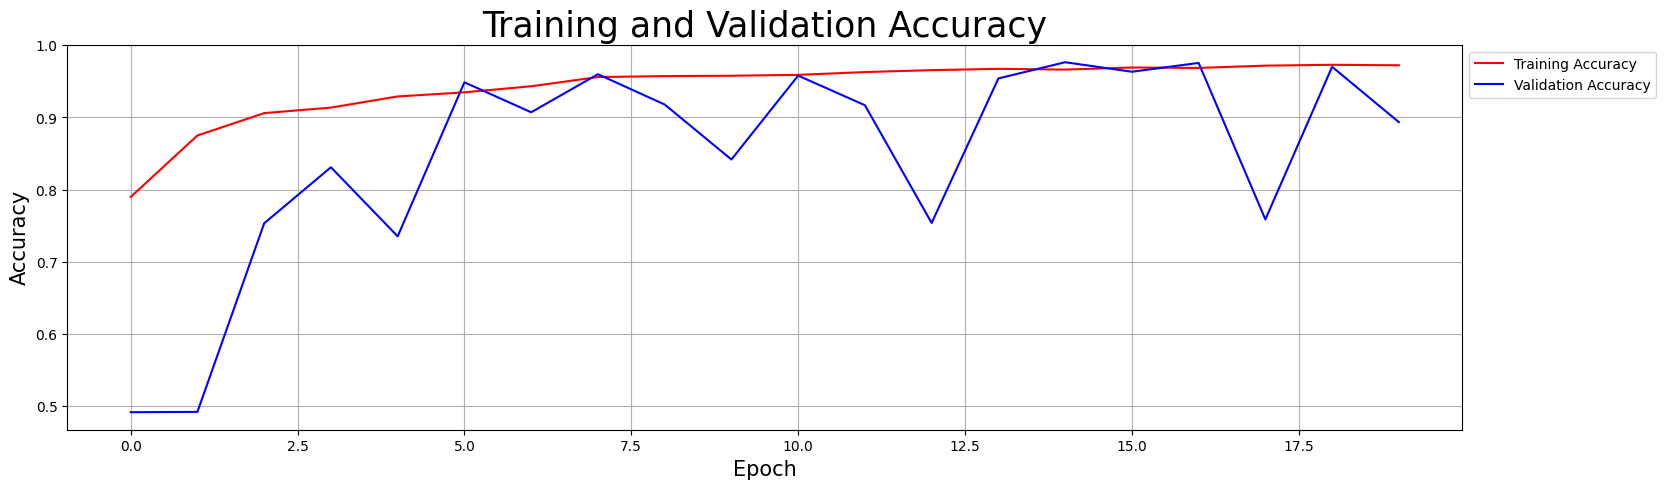

In [ ]:
plot_accuracy(history)

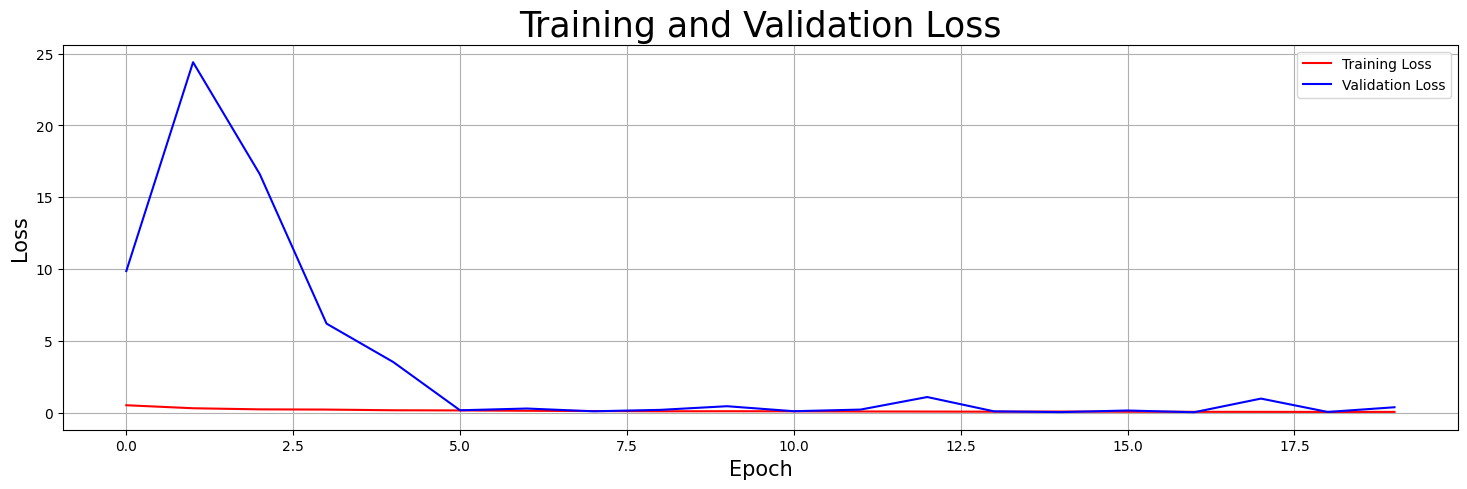

In [ ]:
plot_loss(history)

## Model 2 Plots

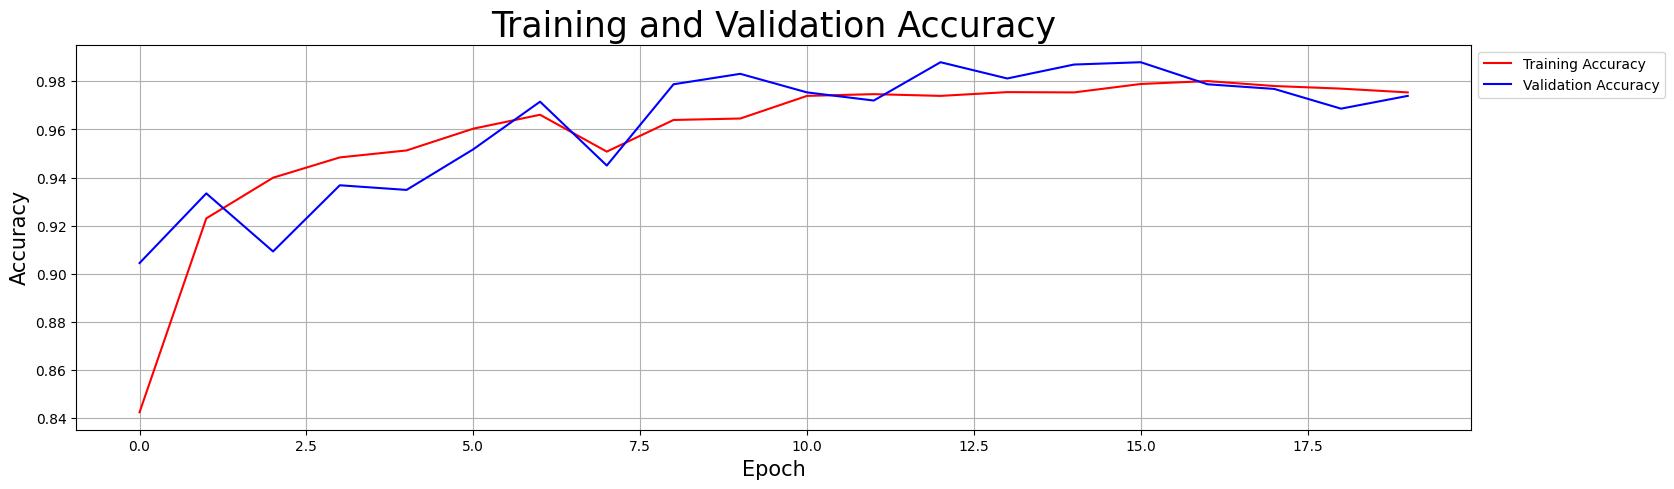

In [ ]:
plot_accuracy(history_2)

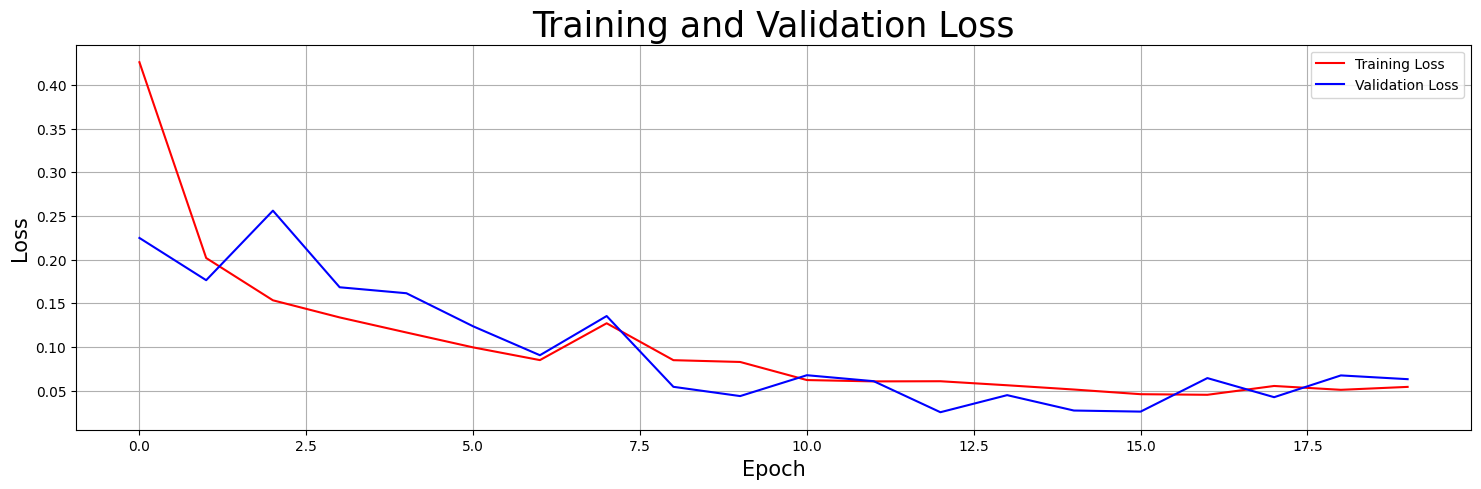

In [ ]:
plot_loss(history_2)